In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import itertools
from collections import defaultdict
from collections import Counter
import io
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations, groupby, chain
from random import sample
import math
import json
import random
import os
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
})
from pyvis.network import Network
from bidict import bidict
import networkx as nx
import time as t
from scipy.stats import binom
%matplotlib ipympl

In [3]:
def n_sols(n,m,quer_dict,noise,n_sols,partial_dict = dict()):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
        M = gp.Model()
        M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    # partial_dict = dict()
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partial_dict)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    return M.SolCount

def gen_sols(n,m,quer_dict,partial_dict,noise,n_sols):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partial_dict)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if M.solCount == 0:
        print("infeasible")
    
    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        out_x = np.zeros_like(x)
        for i in range(len(x)):
            for j in range(len(x[0])):
                out_x[i][j] = x[i][j].Xn
        # print([var.Xn for var in m.getVars()])
        out_lst.append(out_x)
        
    return out_lst, M.Runtime

def quer_cons(M,x,n,quer_dict,noise):
    """ Adds the constraints based on the queries in quer_dict"""
    
    y_var_dict = defaultdict()
    y_p_var_dict = defaultdict()
    y_n_var_dict = defaultdict()
    
    for quer in quer_dict.keys():
        y_var_dict[quer] = []
        y_p_var_dict[quer] = []
        y_n_var_dict[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict[quer].append(M.addVar(vtype='B', name=f"y_{quer}_{i}"))
            y_p_var_dict[quer].append(M.addVar(vtype='B', name=f"y_p_{quer}_{i}"))
            y_n_var_dict[quer].append(M.addVar(vtype='B', name=f"y_n_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict[quer][i] + (len(quer[0])+0.5)*y_p_var_dict[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict[quer][i] + len(quer[0])*y_var_dict[quer][i] + 
                        m*y_p_var_dict[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict[quer][i] + y_p_var_dict[quer][i] + y_n_var_dict[quer][i] == 1)
            
        if noise == 0:
            M.addConstr(sum(y_var_dict[quer]) == quer_dict[quer])
        else:
            M.addConstr(sum(y_var_dict[quer]) <= quer_dict[quer] + noise)
            M.addConstr(sum(y_var_dict[quer]) >= quer_dict[quer] - noise)
    return None

def partial_cons(M,x,n,partial_dict):
    """ Adds the constraints based on the partial information in partial_dict"""
    
    y_var_dict_partial = defaultdict()
    y_p_var_dict_partial = defaultdict()
    y_n_var_dict_partial = defaultdict()
    
    for quer in partial_dict.keys():
        y_var_dict_partial[quer] = []
        y_p_var_dict_partial[quer] = []
        y_n_var_dict_partial[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_partial_{quer}_{i}"))
            y_p_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_p_partial_{quer}_{i}"))
            y_n_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_n_partial_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict_partial[quer][i] + (len(quer[0])+0.5)*y_p_var_dict_partial[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict_partial[quer][i] + len(quer[0])*y_var_dict_partial[quer][i] + 
                        m*y_p_var_dict_partial[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict_partial[quer][i] + y_p_var_dict_partial[quer][i] + y_n_var_dict_partial[quer][i] == 1)
            
        # this line does the work
        M.addConstr(sum(y_var_dict_partial[quer]) >= partial_dict[quer])
        
    return None

def bin_cons(M,x,n):
    """ Adds binary symmetry breaking constraint """
    for i in range(n-1):
        M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    return None

def gen_bin_data_set(n,m):
    """n is number of people, m is number of attributes used, database is uniform random"""
    db = pd.DataFrame(np.random.randint(0,2,size=(n, m)), columns=[f'att_{x}' for x in range(m)])
    return db

def gen_powerset(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def gen_queries_uniform_complete(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return sample(queries,min(n_queries,len(queries)))

def gen_queries_all(m):
    """Generates all possible queries of m binary attributes"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_comp(m):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_uniform(m,n_queries):
    """Generates random queries. Chooses number of attributes uniformly over [1,m],
    Would be interested to see how this changes with a skewed distribution, also
    would be interesting how it changes if symmetry in queries is forced"""
    
    queries = []

    for i in range(n_queries):
        quer = []
        atts = np.random.randint(1,m+1)
        quer.append(tuple(sorted(sample(range(m),atts))))
        quer.append(tuple(np.random.choice([0,1], size=[atts])))
        queries.append(quer)

    queries = list(set([tuple(x) for x in queries]))

    return queries

def gen_partial_info(db,n_part,m_part):
    """ generates a partial info dict based on n_partials rows
    and m_partials attributes per individual, if no partial info, we get None type """
    
    n = db.shape[0]
    m = db.shape[1]
    
    partial_dict = defaultdict(lambda:0)
    
    if n_part == 0 or m_part == 0:
        return partial_dict
    
    row_inds = np.random.choice(n,n_part, replace = False)
    for i in row_inds:
        att_sample = np.random.choice(m,m_part, replace = False)
        lst = []
        for j in att_sample:
            lst.append(int(db[i:i+1][f"att_{j}"]))
            
        # print(att_sample,lst)
        vals = [x for _,x in sorted(zip(att_sample,lst))]
        
        partial_dict[(tuple(sorted(att_sample)),tuple(vals))] += 1
    return partial_dict
            
def quer2string(query):
    """ converts query to a string to be used by pandas 'query' function"""
    string = ""
    for pos, att in enumerate(query[0]):
        string += f'att_{att} == {query[1][pos]} & '
    return string[0:-3]

def get_counts_uniform(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + np.random.randint(-noise,noise+1),0)
    return out_dict

def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def check_fixed_sols(sols):
    """Takes some candidate databases and returns which
    rows are contained in all of them, including duplicates"""
    
    if len(sols) == 1:
        return [tuple(x) for x in sols[0]]
    
    out_lst = []
    for sol in sols:
        temp = []
        for row in sol:
            temp.append(tuple(row))
        out_lst.append(temp)
    # print(out_lst)

    fixed_sols = []
    for row in out_lst[0]:
        count = 0
        for sol in out_lst[1:]:
            if row in sol:
                sol.remove(row)
                count += 1
            # else:
            #     break
        if count == len(sols) - 1:
            fixed_sols.append(row)
    return fixed_sols

def total_sim(sol,db):
    count = 0
    for i, val_i in enumerate(db):
        for j, val_j in enumerate(val_i):
            # print(val_j, sol[i][j])
            if val_j != sol[i][j]:
                count += 1
            
    return  1 - count/(len(db[0])*len(db))

def gen_cij(db,sol,i,j):
    """ computes cost of assigning row i of solution 
    to row j of database in terms of L1 norm"""
    
    cost = sum([abs(db[j][k]-sol[i][k]) for k in range(len(sol[0]))])
    return cost

def ass_ILP(db,sol):
    """ Creates an optimal assignment of rows in the solution 
    to the rows in the true database, the objective function value
    is returned and is the smallest number of differences between
    solution and true database, based on row swapping"""
    
    n = len(sol)
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
               for j in range(n)] for i in range(n)])
    
    for i in range(n):
        M.addConstr(sum(x[i,:]) == 1)
        M.addConstr(sum(x[:,i]) == 1)
        
    M.setObjective(sum([sum([x[i][j]*gen_cij(db,sol,i,j) for j in range(n)]) for i in range(n)]), GRB.MINIMIZE)
    
    M.optimize()
    
    out_x = np.zeros_like(x)
    for i in range(len(x)):
        for j in range(len(x[0])):
            out_x[i][j] = x[i][j].Xn
    # print(out_x)
    
    return 1 - M.ObjVal/(len(db)*len(db[0]))

def get_counts_uniform_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_uniform(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is symmetric rounded triangle [-noise, +noise]
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_triangle(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        if noise == 0:
            actual_noise = 0
        else:
            actual_noise = round(np.random.triangular(-noise, 0, noise))
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + actual_noise,0)
    return out_dict

def quer2noise_uniform(query,quer_seed_dict,noise):
    """ generates noise from discrete-RV: U({-noise,noise})
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return np.random.randint(-noise,noise+1)

def quer2noise_triangle(query,quer_seed_dict,noise):
    """ generates noise from rounded triangle distribution over -noise to +noise, median at 0,
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return round(np.random.triangular(-noise, 0, noise))

def gen_powerset_test(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def flipped_choice(choice):
    """ returns the compliment of a query"""
    return tuple([abs(1-x) for x in choice])

def gen_queries_compliment(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            used = []
            for choice in gen_powerset(i):
                if choice not in used:
                    quer = []
                    used.append(flipped_choice(choice))
                    quer.append(comb)
                    quer.append(choice)
                    queries.append(tuple(quer))
            
            
    sampled = sample(queries,min(int(n_queries/2),len(queries)))
    sample_with_compliment = list(sampled)
    for quer in sampled:
        sample_with_compliment.append((quer[0],flipped_choice(quer[1])))  
    
    return sample_with_compliment

def query_seed_dict(m):
    """ assigns a seed to every possible query based on the m attributes"""
    quer_dict = defaultdict()
    queries = gen_queries_uniform_complete(m,max_quers(m))
    for query in queries:
        quer_dict[query] = int(np.random.uniform()*100000)
    # print(quer_dict)
    return quer_dict

def max_quers(m):
    """returns the maximum number of queries possible from m binary attributes"""
    tot = 0
    for i in range(1,m+1):
        tot += (math.factorial(m)/(math.factorial(i)*math.factorial(m-i)))*(2**i)
    return int(tot)

def gen_query_row_pair(N_q_start,n,m,c,N_sols):
    """ creates a database, and returns pairs of backbone solutions and the additional queries 
    (and their values) it took to find that backbone solution. Starts with N_q_start queries
    and considers N_sols to create the backbone solutions"""
    
    max_quer = max_quers(m)
    print(max_quer)
    noise = c
    db = gen_bin_data_set(n,m)
    display(db)
    
    # might not need to be shuffled, just making sure
    quers = gen_queries_comp(m)
    np.random.shuffle(quers)
    quer_seed_dict = query_seed_dict(m)
    quer_dict_all = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    return_lst = []
    backbones = []
    fixed_sols =[]
    quer_set = set()

    N_q = min(int(N_q_start),max_quer)
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    
    while (len(backbones) != n) and (N_q != max_quer+1):
        
        queries = quers[0:N_q]
        quer_dict = dict((k, quer_dict_all[k]) for k in queries)
        sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
        sols = np.array(sols_all[0], dtype=int) 
        
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            
        if len(fixed_sols) > len(backbones):

            fs_c = Counter(fixed_sols)
            b_c = Counter(backbones)
            if sum(fs_c.values()) > sum(b_c.values()):
                new_bones = [x for x in fs_c-b_c]
            crit_query = {queries[N_q-1]: quer_dict[queries[N_q-1]]}
            return_lst.append((new_bones,crit_query,dictfilt(quer_dict,set(queries).difference(quer_set))))
            backbones += new_bones
            quer_set.update(set(queries))
        N_q += 1
        
    if N_q == max_quer -1:
        print("Used all queries")
    return return_lst
        
def get_results_old(c,n,m,N_q,N_sols,dist,n_part,m_part):
    """ Returns some performance metrics for a randomly generated database, with random noise"""   
    noise = c
    db = gen_bin_data_set(n,m)
    # print(db)
    quers = gen_queries_uniform_complete(m,N_q)
    
    if n_part == 0 or m_part == 0:
        partial_dict = None
    else:
        partial_dict = gen_partial_info(db,n_part,m_part)
    
    if dist == 'uniform':
        quer_dict = get_counts_uniform(db,quers,noise)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle(db,quers,noise)
    else:
        return "unrecognised distribution"
    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
    
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns

def get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict):
    """ Returns some performance metrics for a randomly generated database, with random noise....
    
    db: is database as a pandas array
    seed_dict: a dictionary assigning a seed to every possible query
    quers: a bunch of queries in a two-tuple form, will get turned into a noisy count based on 'db', 'dist' and 'seed_dict'
    c: bound on noise, integer
    n: size of database (eventually want this to get rid of this...)
    m: number of attributes
    N_sols: number of solutions to enumerate when solving
    dist: rn either 'uniform' or 'triangle', the distribution of the noise
    partial_dict: dictionary containing partial information.
    
    """   
    
    
    noise = c
#     # print(db)
#     quers = gen_queries_uniform_complete(m,N_q)
    
#     if n_part == 0 or m_part == 0:
#         partial_dict = None
#     else:
#         partial_dict = gen_partial_info(db,n_part,m_part)


    if dist == 'uniform':
        quer_dict = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,noise,quer_seed_dict)
    else:
        return "unrecognised distribution"

    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    
    sol_set = set()
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        sol_set.add(tuple(sol_tup))
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
            
    
    # print(len(sol_set))
    # print(sols)
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns


def gen_crit_queries(db,m,c):
    outputs = []
    A = tuple(range(m))
    for row in db:
        V = tuple(row)
        for i in range(3):
            outputs.append(((A,V),c+i))
    return outputs

def compare_noise_types(n,m,c,N_q,N_sols,N_trials,n_part,m_part):
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    tri_list = []
    uni_list = []
    unique_counts = defaultdict(lambda:0)
    quer_seed_dict = None
    
    for i in range(N_trials):
        for dist in ['triangle','uniform']:
            quers = gen_queries_uniform_complete(m,N_q)
            db = gen_bin_data_set(n,m)
            partial_dict = gen_partial_info(db,n_part,m_part)
            
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist)
            results[dist].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[dist] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for dist in ['triangle','uniform']:
        df = pd.DataFrame(results[dist])
        out_results[dist] = dict(df.mean()) 
        out_results[dist]['frac_solved_uniqely'] = unique_counts[dist]/N_trials
        out_results[dist]['params'] = {'n': n, 'm': m, 'c': c, 'N_q': N_q, 'N_sols': N_sols, 'N_trials': N_trials}
    return out_results

def gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,first):
    quers_all = gen_queries_uniform_complete(m,max_quers(m))
    if dist == 'uniform': quer_counts = get_counts_uniform_seed(db,quers_all,c,quer_seed_dict)
    if dist == 'triangle': quer_counts = get_counts_triangle_seed(db,quers_all,c,quer_seed_dict)
    
    if first == 'large':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1], reverse = True)}
    elif first == 'small':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1])}
        
    first_Nq_quers = {k: sorted_quers[k] for k in list(sorted_quers.keys())[0:N_q]}
    # print(first_Nq_quers)
    return list(first_Nq_quers.keys())

def gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist):
    
    N_q = min(N_q,max_quers(m))
    all_quers = gen_queries_all(m)
    
    if quer_type == 'uniform_random':
        quers = gen_queries_uniform_complete(m,N_q)
    
    elif quer_type == 'large_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'large')
        
    elif quer_type == 'small_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'small')
        
    elif quer_type == 'many_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]), reverse = True)[0:N_q]
    
    elif quer_type == 'few_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]))[0:N_q]
        
    return quers
        
    

def compare_query_types(n,m,c,N_q,N_sols,N_trials,dist,quer_types):
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        # quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for quer_type in quer_types:
            # partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            
            partial_dict = dict()
            quers = gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[quer_type].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[quer_type] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for quer_type in quer_types:
        df = pd.DataFrame(results[quer_type])
        out_results[quer_type] = dict(df.mean()) 
        out_results[quer_type]['frac_solved_uniqely'] = unique_counts[quer_type]/N_trials
        out_results[quer_type]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
        
    return out_results

def compare_partial_info(n,m,c,N_q,N_sols,N_trials,dist,partials):
    """partials is a list of 2-element lists, where the first position is n_part,
    the number of people to generate partial info from, and second is m_part, 
    the number of attributes for each person to 'know'. Comapres each 2-element list, 
    asking N_q queries on each, averaging N_trials times
    
    should this all be done with additive query style? 
    
    """
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for partial in partials:
            partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[str(partial)].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[str(partial)] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for partial in partials:
        df = pd.DataFrame(results[str(partial)])
        out_results[str(partial)] = dict(df.mean()) 
        out_results[str(partial)]['frac_solved_uniqely'] = unique_counts[tuple(partial)]/N_trials
        out_results[str(partial)]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
    return out_results

def single_basic_run(n,m,c,N_q,N_sols,N_trials,dist,n_part,m_part):
    """ Generates a dataset and solves, averaging over N_trials times.
    returns a dictionary with all the performance 'metrics'"""
    
    out_lst = []
    unique_counts = 0
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        # print(db)
        partial_dict = gen_partial_info(db,n_part,m_part)
        # print(partial_dict)
        temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
        out_lst.append(temp_res)
        if temp_res['N_sols_actual'] == 1:
            unique_counts += 1
            
    df = pd.DataFrame(out_lst)
    out_dict = dict(df.mean()) 
    out_dict['frac_solved_uniqely'] = unique_counts/N_trials

    return out_dict
    
def compare_query_types_additive(n,m,c,N_q_range,N_sols,N_trials,dist,quer_types):
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict()
    out_lst = []
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        db = gen_bin_data_set(n,m)
        quers_all = defaultdict()
        for quer_type in quer_types:
            quers_all[quer_type] = gen_queries(m,n,db,c,quer_seed_dict,max_quers(m),quer_type,dist)
            
        partial_dict = dict()
        for N_q_try in N_q_range:
            N_q = int(min(N_q_try,max_quers(m)))

            temp_dict = defaultdict()
            
            for quer_type in quer_types:
                
                quers = quers_all[quer_type][0:N_q]
                temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
                temp_dict[quer_type] = temp_res
                
            results[N_q] = temp_dict
            
        out_lst.append(results)
    return ave(out_lst)

def ave(d):
    """given a list of nested dictionaries, it will return a dictionary of averages 
    in the same format as the individual dicts"""
    _data = sorted([i for b in d for i in b.items()], key=lambda x:x[0])
    _d = [(a, [j for _, j in b]) for a, b in groupby(_data, key=lambda x:x[0])]
    return {a:ave(b) if isinstance(b[0], dict) else sum(b)/float(len(b)) for a, b in _d}

def get_quer_counts(db,m,c,quer_seed_dict,dist):
    quers = quer_seed_dict.keys()
    if dist == 'uniform':
        quer_dict = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,c,quer_seed_dict)
    else:
        return "unrecognised distribution"
    return quer_dict

def path2filename(path):
    return path.lstrip(os.getcwd())

def my_add_nodes(paths_used,network,res_dict,numbering,node_scaling):
    # net.add_node('a', hidden = True, value = 0)
    path_nodes = Counter()
    # for i in range(min(len(res_dict.values()),paths_used)):
    for i in res_dict.keys():
        path_nodes.update(res_dict[str(i)][0])
        # path_nodes.update([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
    # print(path_nodes)
    not_visited = list(set(numbering.values()) - set(path_nodes.keys()))
    for query in path_nodes.keys():
        net.add_node(query, str(query),
                     size=node_scaling*path_nodes[query], 
                     # value=50, 
                     color = 'blue', 
                     title= str(numbering.inverse[query])+ "\n"+ "visits: " + str(path_nodes[query])
                 # level = len(query[0])
                )
    for query in not_visited:
        net.add_node(query, size=10, color = 'green', title = str(numbering.inverse[query])
                 # level = len(query[0])
                )
    return None

def my_add_edges(paths_used,res_dict,colour,network):
    # network.add_edge(1,1,value = 0, hidden = True)
    # for j in range(min(len(res_dict.values()),paths_used)):
    for j in res_dict.keys():
        path = res_dict[str(j)][0]
        temp_col = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        # print(temp_col)
        for i in range(len(path) - 1):
            # np.random.seed(np.random.choice(range(100000)))
            network.add_edge(int(path[i]),int(path[i+1]), color = temp_col, size =0.1)
    return None

def gen_paths_SA(numbering,N_trials,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k):
    
    results = defaultdict()
    db = gen_bin_data_set(n,m)
    for i in range(N_trials):
        if i%10 ==1:
            print(i)
        quer_seed_dict = query_seed_dict(m)
        quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
        results[i] = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
        
    return results

def gen_paths_SA_additive_k(numbering,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k_low,k_high):
    
    results = defaultdict()
    db = gen_bin_data_set(n,m)
    quer_seed_dict = query_seed_dict(m)
    quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
    for k in range(k_low,k_high+1):
        if k%5 ==1:
            print(k)
        results[k] = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
        
    return results

def genetic_algo(n_iters, pop_size,n_parents, n_crossovers, n_mutants, quer_counts,n,m,c,N_sols,k,numbering):
    largest_number = max_quers(m)
    initial_pop = [np.random.choice(list(range(largest_number)), k, replace = False) for x in range(pop_size)]
    fit_dict = defaultdict()
    for i in initial_pop:
        fit_dict[tuple(i)] = get_fitness(i,n,m,c,quer_counts,N_sols,numbering)
    
    for i in range(n_iters):
        if len(set(fit_dict.keys())) <= 3:
            return list(set(fit_dict.keys()))[0], fit_dict[list(set(fit_dict.keys()))[0]]
        parents = choose_parents(fit_dict,n_parents)
        children = breed(parents,n_crossovers,largest_number)
        pop = parents+children
        pop += mutate(pop,n_mutants,largest_number)
        new_fit_dict = cull(pop,fit_dict,pop_size,n,m,c,quer_counts,N_sols,numbering)
        fit_dict = dict(new_fit_dict)
        
        ####this is a shitty fix - change this
        if len(set(fit_dict.values())) == 1:
            break
    
    min_fit = min(fit_dict.values())
    for i in fit_dict.keys():
        if fit_dict[i] == min_fit:
            return sorted(i), fit_dict[i]
    
def get_fitness(sol,n,m,c,quer_counts,N_sols,numbering):
    quers = []
    for num in sol:
        quers.append(numbering.inverse[num])
    return get_n_sols(n,m,c,quers,quer_counts,N_sols)

def choose_parents(fit_dict,n_parents):
    choices = tuple(fit_dict.keys())
    n_sol_lst = []
    tot = sum(fit_dict.values())
    for choice in choices:
        n_sol_lst.append((fit_dict[choice]))
    if len(set(n_sol_lst)) == 1:
        probs = np.array([1/len(n_sol_lst)]*len(n_sol_lst))
    else:
        probs = []
        max_lst = max(n_sol_lst)
        for i in n_sol_lst:
            prob = (max_lst - i)/sum([max_lst - x for x in n_sol_lst])
            if prob == 0:
                prob += 0.001
            probs.append(prob)
        probs = np.array(probs)
    probs /= probs.sum()
    # print(probs)
    choices_index = np.random.choice(range(len(choices)), n_parents, replace=False, p=probs)
    return [choices[i] for i in choices_index]

def breed(parents,n_crossovers,largest_number):
    children = []
    for i in range(n_crossovers):
        choice_index = np.random.choice(range(len(parents)), 2, replace= False)
        couple = [parents[i] for i in choice_index]
        children += crossover(couple,largest_number)
    return children 

def crossover(couple,largest_number):
    parent1 = couple[0]
    parent2 = couple[1]
    point = np.random.randint(0,len(couple[0])+1)
    child1 = parent1[0:point] + parent2[point:]
    child2 = parent2[0:point] + parent1[point:]
    return [fix_child(child1,largest_number), fix_child(child2,largest_number)]
    
def fix_child(child,largest_number):
    child_set = set(child)
    new_choices = np.random.choice(list(set(range(largest_number))-child_set),len(child) - len(child_set), replace= False )
    return list(child_set.union(new_choices))

def cull(pop,fit_dict,pop_size,n,m,c,quer_counts,N_sols,numbering):
    for i_ in pop:
        i = tuple(i_)
        if i not in fit_dict.keys():
            fit_dict[i] = get_fitness(i,n,m,c,quer_counts,N_sols,numbering)
    sorted_pop = list(sorted(fit_dict.items(), key=lambda x:x[1]))
    culled_pop = [sorted_pop[x][0] for x in range(pop_size)]
    new_fit_dict = defaultdict()
    for i in culled_pop:
        new_fit_dict[i] = fit_dict[i]
    return new_fit_dict

def mutate(pop,n_mutants,largest_number):
    mutant_choice = np.random.choice(range(len(pop)), n_mutants)
    mutated = []
    for choice in mutant_choice:
        ind = pop[choice]
        bit_choice = np.random.choice(range(len(ind)))
        new_ind = list(ind)
        new_quer = int(np.random.choice(list(set(range(largest_number))-set(ind))))
        new_ind[bit_choice] = new_quer
        mutated.append(new_ind)
    return mutated

def simu_annealing(n_iters,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering):
    
    largest_number = max_quers(m)
    fit_dict = defaultdict()
    current_sol = tuple(np.random.choice(list(range(largest_number)), k, replace = False))
    fit_dict['current_sol'] = get_fitness(current_sol,n,m,c,quer_counts,N_sols,numbering)
    temp = t_0
    last_ = [i for i in range(repeats)]
    
    for i in range(n_iters):
        if i >= n_iters*0.5:
            last_[i%repeats] = int(fit_dict['current_sol'])
            if len(set(last_)) == 1:
                # print(i)
                break
        new_sol = find_neighbour(current_sol,largest_number)
        fit_dict['new_sol'] = get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering)
        # print(fit_dict)
        change = fit_dict['new_sol'] - fit_dict['current_sol']
        # print(change)
        p = get_prob(temp,change)
        # print(p)
        if np.random.uniform() < p:
            current_sol = tuple(new_sol)
            fit_dict['current_sol'] = int(fit_dict['new_sol'])
        temp = temp*alpha
    # print(i)
    return (tuple(sorted([int(x) for x in current_sol])), get_fitness(current_sol,n,m,c,quer_counts,N_sols,numbering))
        
def get_prob(temp,change):
    if change <= 0:
        p = 1
    else:
        p = (math.e)**(-change/temp)
    return p
            
def find_neighbour(sol,largest_number):
    bit_choice = np.random.choice(range(len(sol)))
    new_ind = list(sol)
    new_quer = int(np.random.choice(list(set(range(largest_number))-set(sol))))
    new_ind[bit_choice] = new_quer
    return tuple(new_ind)

def produce_paths(db,quer_seed_dict,n,m,c,dist,N_sols,k,N_paths,numbering):
    """k is path length"""
    
    partial_dict = dict()
    all_quers = list(quer_seed_dict.keys()) 

    paths = []
    sols_path_dict = defaultdict()
    backbone_path_dict = defaultdict()
    for i in range(N_paths):
        path = tuple(np.random.choice(list(numbering.inverse.keys()),min(k,max_quers(m)), replace = False))
        paths.append(path)
    for path in paths:
        quers = [numbering.inverse[x] for x in path]
        res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
        sols_path_dict[path] = res['N_sols_actual']
        backbone_path_dict[path] = res['backbone_size']
        
    return sols_path_dict, backbone_path_dict
    
def good_paths(path_dicts, numbering, sol_thresh, bb_thresh):
    """a path is a good path if it has leq sol_thresh number of feasible solutions, 
    or if it has geq bb_thresh backbone fraction."""
    
    good_paths = []
    good_quer_count = Counter()
    quer_count = Counter()

    for path in path_dicts[0].keys():
        quer_count.update(path)
        if path_dicts[0][path] <= sol_thresh or path_dicts[1][path] >= bb_thresh:
            good_paths.append(path)
            good_quer_count.update(path)
    return good_paths, good_quer_count

def quer_perf_avg(path_dicts,numbering):

    quer_score_dict = defaultdict(lambda: 0)
    quer_count = Counter()
    # print(path_dicts)
    
    for path in path_dicts[0].keys():
        quer_count.update(path)
        for quer in path:
            # print(quer)
            quer_score_dict[quer] += path_dicts[0][path]
    for quer in quer_score_dict.keys():
        quer_score_dict[quer] /= quer_count[quer]
    return quer_score_dict

def get_n_sols(n,m,c,quers,quer_counts,N_sols):
    """returns number of feasible there are for choice of queries, where
    info about database + noisy counts is given in quer_counts"""
    quer_dict = defaultdict()
    for quer in quers:
        quer_dict[quer] = quer_counts[quer]
    return n_sols(n,m,quer_dict,c,N_sols)

def produce_count(dist,quer_seed_dict,db,quer,c):
    quers = [quer]
    if dist == 'uniform':
            quer_dict = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,c,quer_seed_dict)
    return list(quer_dict.values())[0]

def sort_quer(quer):
    vals = [x for _,x in sorted(zip(quer[0],quer[1]))]
    return (tuple(sorted(quer[0])),tuple(vals))

def gen_queries_algo(db,m,quer_seed_dict,dist,c,N_q):
    
    quers = defaultdict()
    seeds = np.random.randint(0,100000,1000)
    i=0
    
    while len(quers.keys()) < min(max_quers(m),N_q):
        
        np.random.seed(seeds[i])
        order = list(np.random.choice(list(range(m)),m, replace = False))
        # print(order)
        A = []
        V = []
        for i in order:
            A.append(i)
            quer0 = sort_quer([A,V+[0]])
            quer1 = sort_quer([A,V+[1]])
            
            val0 = produce_count(dist,quer_seed_dict,db,quer0,c)
            val1 = produce_count(dist,quer_seed_dict,db,quer1,c)
            
            # print(val0)
            
            if quer0 in quers.keys():
                V+= [1]
            elif quer1 in quers.keys():
                V+= [0]
            else:
                V += [np.argmax([val0,val1])]
            quers[quer0] = val0
            quers[quer1] = val1
            # print(A,V)
        i+=1
        
    return quers

def produce_alt_paths(sol,T_max,n,m,c,quer_counts,N_sols,numbering):
    largest_number = max_quers(m)
    current_n_sols = get_fitness(sol,n,m,c,quer_counts,N_sols,numbering)
    alt_sols = []
    pop = [list(sol)]
    curr_time = t.time()
    while t.time() <= curr_time + T_max:
        new_sol = mutate(pop,1,largest_number)[0]
        if get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering) <= current_n_sols:
            alt_sols.append(tuple(new_sol))
    return set(alt_sols)

In [4]:
n = 15
m = 7
c = 1
dist = 'uniform'
db = gen_bin_data_set(n,m)
N_sols = 1000
N_sols_pd = 1000
n_queries = 200

time = t.time()
# quers = gen_queries_all(m)
quer_seed_dict = query_seed_dict(m)
quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)

target_quer = gen_queries_uniform_complete(m,1)


sample_quers = gen_queries_uniform_complete(m,n_queries)


# sample_quers = gen_queries_all(m)
current_quers = dict((i,quer_counts[i]) for i in sample_quers)
time1 = t.time()
print(time1-time)

time = t.time()
print(n_sols(n,m,current_quers,c,N_sols))
time1 = t.time()
print(time1-time)
partial_dict = gen_partial_info(db,10,6)
time = t.time()
print(n_sols(n,m,current_quers,c,N_sols,partial_dict))
time1 = t.time()
print(time1-time)

1.4316799640655518
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-15
1000
24.844908714294434
16
14.635986328125


### for multiple queries..

In [5]:
def ask_quers_entropy_multiple(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size):
    all_quers = gen_queries_all(m)
    current_sols = n_sols(n,m,current_quers_dict,c,N_sols)
    remaining_quers = list(set(all_quers) - set(current_quers_dict.keys()))
    # print(current_sols)
    quers_added = []
    while current_sols != 1 and len(remaining_quers) != 0:
        remaining_quers = list(set(all_quers) - set(current_quers_dict.keys()))
        new_quers = next_quers_multiple(n_more_quers,current_quers_dict,current_sols,n,m,c,remaining_quers,dist,N_sols_pd,true_counts,sample_size,all_quer_counts)
        # print(new_quers)
        if new_quers == None:
            break
        # print(new_quers)
        quers_added += new_quers
        # print(quers_added)
        for quer in new_quers:
            # print(quer)
            # print(f'quer_count of the quer: {all_quer_counts[quer]}')
            current_quers_dict[quer] = all_quer_counts[quer]
        remaining_quers = list(set(all_quers) - set(current_quers_dict.keys()))
        # print(current_quers_dict)
        current_sols = n_sols(n,m,current_quers_dict,c,N_sols)
        # print(f'current sols multi: {current_sols}')
    return quers_added

def get_entropy_multiple(prob_dict,poss_quers,current_quers_dict,c,N_sols,m,current_sols,all_quer_counts):
    entropy = 0
    temp_quer_dict = dict(current_quers_dict)
    for quer in poss_quers:
        temp_quer_dict[quer] = all_quer_counts[quer]
    n_sols_val = n_sols(n,m,temp_quer_dict,c,N_sols)
    diff = current_sols - n_sols_val
    if n_sols_val != 0:
        # entropy += prob_dict[poss_quer][quer_val]*math.log2(1/n_sols_val)
        # entropy += prob_dict[poss_quer][quer_val]*math.log2(current_sols/n_sols_val)
        entropy += diff
        # entropy += prob_dict[poss_quer][quer_val]*n_sols_val
    return entropy

def next_quers_multiple(n_more_quers,current_quers_dict,current_sols,n,m,c,remaining_quers,dist,N_sols_pd,true_counts,sample_size,all_quer_counts):
    poss_prob_dict = defaultdict(lambda: defaultdict())
    choice = np.random.choice(range(len(remaining_quers)), min(sample_size,len(remaining_quers)))
    # for poss_quer in [remaining_quers[x] for x in choice]:
#     for poss_quer in remaining_quers:
#         # print("____")
#         # print(poss_quer)
#         # poss_prob_dict[poss_quer] = gen_prob_dict_bad(current_quers_dict,n,m,c,[poss_quer],N_sols_pd,dist)
        
        
#         # poss_prob_dict[poss_quer] = gen_prob_dict_better(current_quers_dict,n,m,c,[poss_quer],N_sols_pd,dist)
#         # print(all_quer_counts[poss_quer])
#         # print(poss_prob_dict[poss_quer].values())
        
        
#         # actual_vals = [max(x,0) for x in range(true_counts[poss_quer]-0,true_counts[poss_quer]+0+1)]
#         # poss_prob_dict[poss_quer] = dict((x,1/len(actual_vals)) for x in actual_vals)
        
#         poss_prob_dict[poss_quer] = {all_quer_counts[poss_quer]: 1}
        
        # print(poss_prob_dict)
    entropy_dict = defaultdict()
    # for poss_quer in [remaining_quers[x] for x in choice]:
    
    
    for poss_quers in combinations(remaining_quers, n_more_quers):
        entropy_dict[tuple(poss_quers)] = get_entropy_multiple(poss_prob_dict,poss_quers,current_quers_dict,c,N_sols,m,current_sols,all_quer_counts)
        
    if set(entropy_dict.values()) == set([0]):
        return None
    sorting = sorted(entropy_dict.items(), key=lambda item: item[1], reverse = True)
    # print(sorting)
    return sorting[0][0]
    

### for single queries...

In [6]:
def gen_prob_dict_bad_cheating(true_counts,poss_quer,c,n,feasible_sols):
    """combines still cheating and bad, looks at the intersection between the 
    two feasible regions and then assigns a uniform dist to those values"""
    
    actual_vals = set([min(max(x,0),n+c) for x in range(true_counts[poss_quer]-c,true_counts[poss_quer]+c+1)])
    lst = []
    for sol in feasible_sols:
        sol_db = pd.DataFrame(sol, columns=[f'att_{x}' for x in range(m)])
        lst.append(get_counts_uniform(sol_db,[poss_quer],0)[tuple([poss_quer][0])])
    lst_condensed = list(set(lst))
    # print(lst_condensed)
    feas_vals = set([x for x in range(max(min(lst_condensed) - c,0), min(max(lst_condensed) + c + 1, n+c))])
    intersection = list(actual_vals.intersection(feas_vals))
    return dict((x,1/len(intersection)) for x in intersection)

def gen_prob_dict_still_cheating(true_counts,poss_quer,c,n):
    """uses the same pdf as the noisy count (assuming uniform)"""
    
    actual_vals = [min(max(x,0),n+c) for x in range(true_counts[poss_quer]-c,true_counts[poss_quer]+c+1)]
    return dict((x,1/len(actual_vals)) for x in actual_vals)

def gen_prob_dict_bad_binom(current_quers_dict,n,m,c,poss_quer,dist,feasible_sols,p):
    """ generates the prob dict by looking at all the possible values a particular queries could take
    based on the values found in the feasible solutions then extending this range by adding noise, 
    then assigning binom distribution to all these values, with parameter p, n is taken to be the number
    of feasible values the noisy counting query could have.
    
    Key detail is that this one doesn't cheat. i.e. only uses information that it actually would be allowed to use.
    """
    
    # feasible_sols = gen_sols(n,m,current_quers_dict,dict(),c,N_sols_pd)[0]
    lst = []
    for sol in feasible_sols:
        sol_db = pd.DataFrame(sol, columns=[f'att_{x}' for x in range(m)])
        lst.append(get_counts_uniform(sol_db,[poss_quer],0)[tuple([poss_quer][0])])
    lst_condensed = list(set(lst))
    # print(lst_condensed)
    
    
    #understanding what the true counts of the query is
    poss_vals = [x for x in range(max(min(lst_condensed) - c,0), min(max(lst_condensed) + c + 1, n+c))]
    # poss_vals = [x for x in range(max(min(lst_condensed),0), min(max(lst_condensed), n))]
    
    
    prob_dict = dict()
    for i in range(len(poss_vals)):
        prob_dict[poss_vals[i]] = binom.pmf(i, len(poss_vals), p, 0)
    # print(prob_dict)
    # return shift_probs(prob_dict,n,c)
    return prob_dict

def gen_prob_dict_bad_uniform(current_quers_dict,n,m,c,poss_quer,dist,feasible_sols):
    """ generates the prob dict by looking at all the possible values a particular queries could take
    based on the values found in the feasible solutions then extending this range by adding noise, 
    then assigning uniform distribution to all these values
    
    Key detail is that this one doesn't cheat. i.e. only uses information that it actually would be allowed to use.
    """
    
    # feasible_sols = gen_sols(n,m,current_quers_dict,dict(),c,N_sols_pd)[0]
    lst = []
    for sol in feasible_sols:
        sol_db = pd.DataFrame(sol, columns=[f'att_{x}' for x in range(m)])
        lst.append(get_counts_uniform(sol_db,[poss_quer],0)[tuple([poss_quer][0])])
    lst_condensed = list(set(lst))
    # print(lst_condensed)
    poss_vals = [x for x in range(max(min(lst_condensed) - c,0), min(max(lst_condensed) + c + 1, n+c))]
    prob_dict = dict()
    for i in poss_vals:
        prob_dict[i] = 1/len(poss_vals)
    # print(prob_dict)
    return prob_dict
    

def gen_prob_dict_bad(current_quers_dict,n,m,c,poss_quer,dist,feasible_sols):
    """ uses frequencies of counts found feasible solutions, then creating a probability distribution
    based on these values and then 'shifting' them to accomodate the noise assuming uniform distribution
    
    Key detail is that this one doesn't cheat. i.e. only uses information that it actually would be allowed to use.
    """
    # feasible_sols = gen_sols(n,m,current_quers_dict,dict(),c,N_sols_pd)[0]
    lst = []
    for sol in feasible_sols:
        sol_db = pd.DataFrame(sol, columns=[f'att_{x}' for x in range(m)])
        if dist == 'uniform':
            lst.append(get_counts_uniform(sol_db,[poss_quer],0)[tuple([poss_quer][0])])
        elif dist == 'triangle':
            lst.append(get_counts_triangle(sol_db,[poss_quer],0)[tuple([poss_quer][0])])
    return(create_prob_dict(lst,n,c))

def create_prob_dict(counts,n,c):
    prob_dict = defaultdict(lambda: 0)
    counter = Counter(counts)
    for i in range(0,n+c+1):
        prob_dict[i] = counter[i]/len(counts)
    return shift_probs(prob_dict,n,c)

def shift_probs(prob_dict,n,c):
    new_dict = defaultdict(lambda:0)
    for val in prob_dict.keys():
        for i in range(val-c, val+c+1):
            #this only works for uniform distribution...
            new_dict[min(max(i,0),n+c)] += (1/(2*c + 1))*prob_dict[val]
    return new_dict
    
def get_entropy(prob_dict,poss_quer,current_quers_dict,c,N_sols,m,current_sols):
    entropy = 0
    for quer_val in prob_dict[poss_quer].keys():
        # print(quer_val)
        if prob_dict[quer_val] != 0:
            temp_quer_dict = dict(current_quers_dict)
            temp_quer_dict[poss_quer] = quer_val
            n_sols_val = n_sols(n,m,temp_quer_dict,c,N_sols)
            diff = current_sols - n_sols_val
            if n_sols_val != 0:
                # entropy += prob_dict[poss_quer][quer_val]*math.log2(1/n_sols_val)
                # entropy += prob_dict[poss_quer][quer_val]*math.log2(current_sols/n_sols_val)
                entropy += prob_dict[poss_quer][quer_val]*diff
                # entropy += prob_dict[poss_quer][quer_val]*n_sols_val
    return entropy

def next_quers(n_more_quers,current_quers_dict,current_sols,n,m,c,remaining_quers,dist,N_sols_pd,true_counts,sample_size,all_quer_counts,method,p_binom):
    poss_prob_dict = defaultdict(lambda: defaultdict())
    choice = np.random.choice(range(len(remaining_quers)), min(sample_size,len(remaining_quers)))
    
    # if method == 'bad_uniform' or method == 'bad' or method == 'bad_binom':
    feasible_sols = gen_sols(n,m,current_quers_dict,dict(),c,N_sols_pd)[0]
    
    
    if method == 'stdev':
        return std_dev_choice
    
    for poss_quer in remaining_quers:
        if method == True:
            # poss_prob_dict[poss_quer] = {all_quer_counts[poss_quer]: 1}
            poss_prob_dict[poss_quer] = gen_prob_dict_bad_cheating(true_counts,poss_quer,c,n,feasible_sols)
        elif method == 'still_cheating':
            poss_prob_dict[poss_quer] = gen_prob_dict_still_cheating(true_counts,poss_quer,c,n)
        elif method == 'bad_uniform':
            poss_prob_dict[poss_quer] = gen_prob_dict_bad_uniform(current_quers_dict,n,m,c,poss_quer,dist,feasible_sols)
        elif method == 'bad_binom':
            poss_prob_dict[poss_quer] = gen_prob_dict_bad_binom(current_quers_dict,n,m,c,poss_quer,dist,feasible_sols,p_binom)
        elif method == 'bad':
            poss_prob_dict[poss_quer] = gen_prob_dict_bad(current_quers_dict,n,m,c,poss_quer,dist,feasible_sols)
    
    
    # print(poss_prob_dict)
    entropy_dict = defaultdict()
    for poss_quer in remaining_quers:
        entropy_dict[poss_quer] = get_entropy(poss_prob_dict,poss_quer,current_quers_dict,c,N_sols,m,current_sols)
        
    if set(entropy_dict.values()) == set([0]):
        print("no good queries left")
        return None
    sorting = sorted(entropy_dict.items(), key=lambda item: item[1], reverse = True)
    # print(sorting)
    selected = [sorting[x][0] for x in range(n_more_quers)] 
    
    
    std_dev_choice = [feasible_stats(feasible_sols,remaining_quers,n,m,c,true_counts,all_quer_counts,entropy_dict, current_quers_dict)]
    
    return selected

    
def ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = True,p_binom = 0.5):
    all_quers = gen_queries_all(m)
    current_quers_dict_cp = dict(current_quers_dict)
    current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
    remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
    # print(remaining_quers)
    print(f'starting current sols: {current_sols}')
    print('Printing Format: [number_of_possible_values, true_value, noise_added, expected_reduction_in_sols, heuristic_score] \n')
    
    print('\n'+'\'Optimal\' Method:')
    print('___________________')
    
    quers_added = []
   
    while current_sols != 1 and len(remaining_quers) != 0:
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        new_quers = next_quers(n_more_quers,current_quers_dict_cp,current_sols,n,m,c,remaining_quers,dist,N_sols_pd,true_counts,sample_size, \
                               all_quer_counts,method,p_binom)
        if new_quers == None:
            break
        # print(new_quers)
        quers_added += new_quers
        # print(quers_added)
        for quer in new_quers:
            # print(quer)
            # print(f'quer_count of the quer: {all_quer_counts[quer]}')
            current_quers_dict_cp[quer] = all_quer_counts[quer]
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        # print(get_score_dict(current_quers_dict_cp,m))
        if len(remaining_quers) == 0:
            print('---used all queries---')
        # print(current_quers_dict)
        current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
        print(f'current sols: {current_sols}')
    print(f'Used {max_quers(m) - len(remaining_quers)} total queries')
    return quers_added

def feasible_stats(feasible_sols,remaining_quers,n,m,c,true_counts,all_quer_counts,entropy_dict, current_quers_dict):
    ### want to produce some statistics about different attribute-values relating to the feasible solutions
    ### i.e. variance of true query counts across all the solutions, interactions between different attribute-values
    
    att_val_score_dict = get_score_dict(current_quers_dict,m,true_counts)
    ## uses small = True for this.... something to watch out for
    quer_score_dict = score_quers(remaining_quers,att_val_score_dict,True)
    
    stat_dict = dict()
    for query in remaining_quers:
        lst =[]
        for sol in feasible_sols:
            sol_db = pd.DataFrame(sol, columns=[f'att_{x}' for x in range(m)])
            lst.append(get_counts_uniform(sol_db,[query],0)[tuple([query][0])])
        # stat_dict[query] = np.std(lst)
        stat_dict[query] = [max(lst) - min(lst), true_counts[query], all_quer_counts[query] - true_counts[query], round(entropy_dict[query],2), 
                            round(quer_score_dict[query],2)]
        
    sorting = sorted(stat_dict.items(), key=lambda item: item[1][3], reverse = True)
    print(sorting)
    selected = sorting[0][0]
    return selected
            

In [7]:
def get_score_dict(quer_dict,m,true_counts,base=2):
    """intuition behind base 2 comes from the knowledge that underlying distribution 
    of generated attributes is even (i.e. 0.5 prob assigned to each att value), so
    including another attribute into the query is expected to reduce the query size
    by a half"""
    
    count_dict = defaultdict(lambda: [0,0])
    val_dict = defaultdict(lambda: [0,0])
    for query in quer_dict.keys():
        for i,j in zip(query[0],query[1]):
            count_dict[i][j] += 1
            val_dict[i][j] += quer_dict[query]*base**len(query[0])
            # val_dict[i][j] += true_counts[query]*base**len(query[0])
            
            
    out_dict = defaultdict(lambda: [0,0])
    for pair in count_dict.keys():
        if count_dict[pair][0] != 0:
            out_dict[pair][0] = val_dict[pair][0]/(count_dict[pair][0]*n)
        elif count_dict[pair][0] == 0:
            out_dict[pair][0] = 0
        if count_dict[pair][1] != 0:
            out_dict[pair][1] = val_dict[pair][1]/(count_dict[pair][1]*n)
        elif count_dict[pair][1] == 0:
            out_dict[pair][1] = 0   

    return out_dict

def len_dist(m):
    """returns the maximum number of queries possible from m binary attributes"""
    out_dict = dict()
    for i in range(1,m+1):
        out_dict[i] = (math.factorial(m)/(math.factorial(i)*math.factorial(m-i)))*(2**i)
    return out_dict

# def pick_best(score_dict,tried,quer_len):
#     out_dict = dict()
#     for i in score_dict.keys():
#         if i not in tried.keys():
#             out_dict[i] = max(score_dict[i])
#         elif len(tried[i]) == 2:
#             next
#         else:
#             out_dict[i] = score_dict[int(abs(1-tried[i]))]
#     sorting = sorted(out_dict.items(),  key=lambda item: item[1], reverse = True)
#     atts, vals = zip(*sorting)
#     picked = (atts[0:quer_len],vals[0:quer_len])
#     return picked
    
    
# def pick_quer(score_dict,quer_len,m,already_asked):
#     tried = dict()
#     while choice not in already_asked:
#         choice = pick_best(score_dict,tried,quer_len)
#         tried
        
def remaining_quers_sorting(remaining_quers):
    out_dict = defaultdict(list)
    for quer in remaining_quers:
        out_dict[len(quer[0])].append(quer)
    return out_dict

def score_quers(quers,score_dict,small):
    out_dict = defaultdict(lambda:0)
    for quer in quers:
        # print(quer)
        for i,j in zip(quer[0],quer[1]):
            out_dict[quer] += score_dict[i][j]
        if small == True:
            out_dict[quer] /= 2**len(quer[0])
        elif small == False:
            out_dict[quer] /= len(quer[0])
        
    return out_dict

def pick_new(quer_dict,score_dict,remaining_quers,m,len_dist,small,current_len_dist = None):
    
    ###pick length of a a query based on which len has been neglected the most relative to some distribution
    ### choose the attribute values based on the ones that have the highest score, if they have already been asked, 
    ### go for a similar one, changing one attribute at a time until this combination hasnt been asked yet 
    ### need to decide on an order for this
    
    ### current len dist is calculated each time this is called, but it would be faster to store this and update it
    ### same is true for score dict?
    
    current_len_dist = Counter([len(query[0]) for query in quer_dict.keys()])
    
    diff_dict = dict((i,abs(len_dist[i] - current_len_dist[i])) for i in range(1,m+1))
    quer_len_order = sorted(diff_dict.items(),  key=lambda item: item[1], reverse = True)
    
    ordering_remaining_quers = remaining_quers_sorting(remaining_quers)
    for i in range(m):
        len_choice = quer_len_order[i][0]
        if len(ordering_remaining_quers[len_choice]) != 0:
            break
            
            
    # scores = score_quers(ordering_remaining_quers[len_choice],score_dict)
    scores = score_quers(remaining_quers,score_dict,small)
    
    return sorted(scores.items(),  key=lambda item: item[1], reverse = True)[0][0]

def run_ILP_score_dict(current_quers_dict_cp,remaining_quers,n,m,c,N_sols_pd,choice_size):
    feasible_sols = gen_sols(n,m,current_quers_dict_cp,dict(),c,N_sols_pd)[0]
    stat_dict = dict()
    remove_quers = []
    for query in remaining_quers:
        lst =[]
        for sol in feasible_sols:
            sol_db = pd.DataFrame(sol, columns=[f'att_{x}' for x in range(m)])
            lst.append(get_counts_uniform(sol_db,[query],0)[tuple([query][0])])
        stat_dict[query] = len(set(lst))
        if stat_dict[query] == 1:
            remove_quers.append(query)
    # print(stat_dict)
    
    leftover = list(set(remaining_quers) - set(remove_quers))
            
    sorting = sorted(leftover, key=lambda item: stat_dict[item], reverse = True)
    new_quers = [sorting[x] for x in range(min(choice_size,len(leftover)))]
    return new_quers, remove_quers, leftover

def ask_quers_score_dict_ILP(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,small=True):
    all_quers = gen_queries_all(m)
    min_feas_sols = n_sols(n,m,dict((i,all_quer_counts[i]) for i in all_quers),c,N_sols)
    current_quers_dict_cp = dict(current_quers_dict)
    current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
    remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
    print('\n'+f'Heuristic Method ILP ({small}):')
    print('___________________')
    print(f'starting current sols: {current_sols}')
    quers_added = []
    len_dist_target = len_dist(m)
    counter = 0 
    sol_count_lst = [current_sols]
    ignore = []
    tries = 1
    while current_sols > min_feas_sols and len(remaining_quers) != 0:
        counter += 1
        
        score_dict = get_score_dict(current_quers_dict_cp,m,true_counts)
        
        if (current_sols <= 100 and tries == 1) or (current_sols <= 5 and tries == 0):
            tries -=1
            choice_size = 4
            ILP_out = run_ILP_score_dict(current_quers_dict_cp,remaining_quers,n,m,c,N_sols_pd,choice_size)
            new_quers = ILP_out[0]
            ignore = ILP_out[1]
            print(f'ignores: {ignore}')
        else:
            new_quers = [pick_new(current_quers_dict_cp,score_dict,remaining_quers,m,len_dist_target,small,current_len_dist = None)]
            
        print(f'heuristic algorithm_ILP_{small}: {new_quers}')
        # quers_added += new_quers

        for quer in new_quers:
            if current_sols > min_feas_sols:
                quers_added.append(quer)
                current_quers_dict_cp[quer] = all_quer_counts[quer]
                remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()) - set(ignore))
                if len(remaining_quers) == 0:
                    print('---used all queries---')
                current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
                print(f'current sols: {current_sols}')
                sol_count_lst.append(current_sols)
            else:
                break
            # print('remaining quers:',remaining_quers)
    current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
    print(f'current sols: {current_sols}')
    print(f'Used {len(quers_added)} total queries')
    return quers_added, sol_count_lst
    
    
def ask_quers_score_dict(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,small=True):
    all_quers = gen_queries_all(m)
    min_feas_sols = n_sols(n,m,dict((i,all_quer_counts[i]) for i in all_quers),c,N_sols)
    current_quers_dict_cp = dict(current_quers_dict)
    current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
    remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
    print('\n'+f'Heuristic Method ({small}):')
    print('___________________')
    print(f'starting current sols: {current_sols}')
    quers_added = []
    len_dist_target = len_dist(m)
    counter = 0 
    sol_count_lst = [current_sols]
    while current_sols > min_feas_sols and len(remaining_quers) != 0:
        counter += 1
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        score_dict = get_score_dict(current_quers_dict_cp,m,true_counts)
        new_quers = [pick_new(current_quers_dict_cp,score_dict,remaining_quers,m,len_dist_target,small,current_len_dist = None)]
        print(f'heuristic algorithm_{small}: {new_quers}')
        quers_added += new_quers
        # print(quers_added)
        for quer in new_quers:
            # print(quer)
            # print(f'quer_count of the quer: {all_quer_counts[quer]}')
            current_quers_dict_cp[quer] = all_quer_counts[quer]
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        # print(att_value_counter(current_quers_dict_cp,m))
        if len(remaining_quers) == 0:
            print('---used all queries---')
        # print(current_quers_dict)
        # print(remaining_quers)
        
        # if counter%1 == 0:
        
        current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
        print(f'current sols: {current_sols}')
        sol_count_lst.append(current_sols)
    print(f'Used {max_quers(m) - len(remaining_quers)} total queries')
    return quers_added, sol_count_lst

def ask_quers_random(current_quers_dict,n,m,c,dist,N_sols,all_quer_counts):
    all_quers = gen_queries_all(m)
    min_feas_sols = n_sols(n,m,dict((i,all_quer_counts[i]) for i in all_quers),c,N_sols)
    current_quers_dict_cp = dict(current_quers_dict)
    current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
    remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
    print('\n'+'Random Quers:')
    print('___________________')
    print(f'starting current sols: {current_sols}')
    quers_added = []
    counter = 0 
    sol_count_lst = [current_sols]
    while current_sols > min_feas_sols and len(remaining_quers) != 0:
        counter += 1
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        # score_dict = get_score_dict(current_quers_dict_cp,m)
        new_quers = [remaining_quers[np.random.choice(len(remaining_quers))]]
        print(f'random choice: {new_quers}')
        quers_added += new_quers
        for quer in new_quers:
            current_quers_dict_cp[quer] = all_quer_counts[quer]
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        # print(att_value_counter(current_quers_dict_cp,m))
        if len(remaining_quers) == 0:
            print('---used all queries---')
        current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
        print(f'current sols: {current_sols}')
        sol_count_lst.append(current_sols)
    print(f'Used {max_quers(m) - len(remaining_quers)} total queries')
    return quers_added, sol_count_lst

def ask_quers_large_counts(current_quers_dict,n,m,c,dist,N_sols,all_quer_counts,true_counts):
    all_quers = gen_queries_all(m)
    min_feas_sols = n_sols(n,m,dict((i,all_quer_counts[i]) for i in all_quers),c,N_sols)
    current_quers_dict_cp = dict(current_quers_dict)
    current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
    remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
    print('\n'+'Large_count Quers:')
    print('___________________')
    print(f'starting current sols: {current_sols}')
    quers_added = []
    counter = 0 
    sol_count_lst = [current_sols]
    while current_sols > min_feas_sols and len(remaining_quers) != 0:
        counter += 1
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        # score_dict = get_score_dict(current_quers_dict_cp,m)
        sorting = sorted(remaining_quers, key=lambda item: true_counts[item], reverse = True)
        new_quers = [sorting[0]]
        print(f'large count choice: {new_quers}')
        quers_added += new_quers
        for quer in new_quers:
            current_quers_dict_cp[quer] = all_quer_counts[quer]
        remaining_quers = list(set(all_quers) - set(current_quers_dict_cp.keys()))
        # print(att_value_counter(current_quers_dict_cp,m))
        if len(remaining_quers) == 0:
            print('---used all queries---')
        current_sols = n_sols(n,m,current_quers_dict_cp,c,N_sols)
        print(f'current sols: {current_sols}')
        sol_count_lst.append(current_sols)
    print(f'Used {max_quers(m) - len(remaining_quers)} total queries')
    return quers_added, sol_count_lst

In [12]:
n = 10
m = 5
c = 1
dist = 'uniform'
N_trials = 1

results = {'uniform': 0, 'p=0.5': 0, 'p_high': 0, 'p_low': 0}
for trial in range(N_trials):
    # print(trial)
    db = gen_bin_data_set(n,m)
    display(db)
    N_sols = 10000
    N_sols_pd = 1000
    n_queries = 20
    n_more_quers = 1
    n_more_quers_multi = 3
    sample_size = 100
    quers = gen_queries_all(m)
    quer_seed_dict = query_seed_dict(m)
    all_quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
    true_counts = get_quer_counts(db,m,0,quer_seed_dict,dist)
    # print(all_quer_counts)
    sample_quers = gen_queries_uniform_complete(m,n_queries)
    current_quers_dict = dict((i,all_quer_counts[i]) for i in sample_quers)
    print(current_quers_dict)
    # print(get_score_dict(current_quers_dict,m))
    print(f'Using all queries: {n_sols(n,m,dict((i,all_quer_counts[i]) for i in gen_queries_all(m)),c,N_sols)}')
    # print(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = True))
    print(ask_quers_score_dict_ILP(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts))
    # print(ask_quers_score_dict(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts))
    # print(ask_quers_score_dict(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,False))
    # print(ask_quers_random(current_quers_dict,n,m,c,dist,N_sols,all_quer_counts))
    # print(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = 'stdev'))
    # print(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = 'still_cheating'))
    # results['uniform'] += len(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = 'bad_uniform'))/N_trials
    # results['p=0.5'] += len(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = 'bad_binom'))/N_trials
    # results['p_high'] += len(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = 'bad_binom',p_binom = 0.9))/N_trials
    # results['p_low'] += len(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = 'bad_binom',p_binom = 0.3))/N_trials
    # print(ask_quers_entropy(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,sample_size,method = 'bad'))
    # current_quers_dict = dict((i,all_quer_counts[i]) for i in sample_quers)
    # print(len(ask_quers_entropy_multiple(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers_multi,all_quer_counts,true_counts,sample_size)))
# display(results)

,att_0,att_1,att_2,att_3,att_4
0,0,1,0,0,1
1,1,1,0,1,1
2,0,1,0,1,1
3,0,1,0,1,0
4,0,1,0,0,1
5,0,0,0,0,1
6,0,1,1,1,1
7,0,0,0,0,0
8,1,0,0,1,1
9,0,1,0,1,0


{((0, 2), (1, 0)): 2, ((0, 1, 2), (1, 1, 1)): 0, ((0,), (0,)): 8, ((0, 1, 3, 4), (1, 1, 1, 1)): 1, ((1, 2, 3, 4), (0, 0, 1, 0)): 0, ((0, 2, 3, 4), (0, 1, 0, 1)): 1, ((1, 2, 4), (1, 0, 1)): 3, ((0, 1, 2, 3), (0, 1, 0, 0)): 1, ((0, 3), (0, 1)): 4, ((0, 2), (0, 0)): 6, ((1, 3, 4), (0, 1, 1)): 1, ((0, 1, 2), (0, 1, 0)): 6, ((0, 1, 2, 4), (0, 0, 0, 0)): 0, ((0, 3), (1, 0)): 1, ((0, 1, 3), (1, 0, 0)): 0, ((2, 3, 4), (1, 0, 0)): 1, ((0, 1, 2, 3, 4), (1, 0, 1, 1, 0)): 0, ((0, 1, 2, 3), (0, 1, 0, 1)): 3, ((0, 2, 3), (1, 0, 1)): 1, ((0, 1, 4), (1, 0, 0)): 0}
Using all queries: 1

Heuristic Method ILP (True):
___________________
starting current sols: 10000
heuristic algorithm_ILP_True: [((1,), (1,))]
current sols: 10000
heuristic algorithm_ILP_True: [((0, 1), (0, 1))]
current sols: 10000
heuristic algorithm_ILP_True: [((1, 2), (1, 0))]
current sols: 10000
heuristic algorithm_ILP_True: [((2,), (0,))]
current sols: 10000
heuristic algorithm_ILP_True: [((1, 4), (1, 1))]
current sols: 10000
heuristi

In [13]:
n = 10
m = 5
c = 1
dist = 'uniform'
N_trials = 20

results = {'uniform': 0, 'p=0.5': 0, 'p_high': 0, 'p_low': 0}
heuristic_small_res = {'quers': [], 'n_sols': []}
heuristic_small_ILP_res = {'quers': [], 'n_sols': []}
heuristic_res = {'quers': [], 'n_sols': []}
random_res = {'quers': [], 'n_sols': []}
large_counts_res = {'quers': [], 'n_sols': []}
for trial in range(N_trials):
    print(f'------------{trial}---------------')
    db = gen_bin_data_set(n,m)
    N_sols = 3000
    N_sols_pd = 1000
    n_queries = 20
    n_more_quers = 1
    n_more_quers_multi = 3
    sample_size = 100
    quers = gen_queries_all(m)
    quer_seed_dict = query_seed_dict(m)
    all_quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
    true_counts = get_quer_counts(db,m,0,quer_seed_dict,dist)
    # print(all_quer_counts)
    sample_quers = gen_queries_uniform_complete(m,n_queries)
    current_quers_dict = dict((i,all_quer_counts[i]) for i in sample_quers)
    print(current_quers_dict)
    # print(get_score_dict(current_quers_dict,m))
    # heuristic_small = ask_quers_score_dict(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts)
    # heuristic_small_res['quers'].append(heuristic_small[0])
    # heuristic_small_res['n_sols'].append(heuristic_small[1])
    
    heuristic_small_ILP = ask_quers_score_dict_ILP(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts)
    heuristic_small_ILP_res['quers'].append(heuristic_small_ILP[0])
    heuristic_small_ILP_res['n_sols'].append(heuristic_small_ILP[1])
    
    # heuristic = ask_quers_score_dict(current_quers_dict,n,m,c,dist,N_sols,N_sols_pd,n_more_quers,all_quer_counts,true_counts,small=False)
    # heuristic_res['quers'].append(heuristic[0])
    # heuristic_res['n_sols'].append(heuristic[1])
    
    random = ask_quers_random(current_quers_dict,n,m,c,dist,N_sols,all_quer_counts)
    random_res['quers'].append(random[0])
    random_res['n_sols'].append(random[1])
    
    large_counts = ask_quers_large_counts(current_quers_dict,n,m,c,dist,N_sols,all_quer_counts,true_counts)
    large_counts_res['quers'].append(large_counts[0])
    large_counts_res['n_sols'].append(large_counts[1])
    
# print(heuristic_small_res)
print(heuristic_small_ILP_res)
# print(heuristic_res)
print(random_res)
print(large_counts_res)

------------0---------------
{((1, 2, 4), (1, 0, 0)): 3, ((0, 2, 3, 4), (1, 0, 0, 1)): 1, ((1, 3, 4), (1, 0, 1)): 0, ((0, 1, 3, 4), (1, 0, 1, 0)): 0, ((0, 1, 3, 4), (0, 0, 0, 1)): 0, ((0, 1, 3, 4), (1, 0, 0, 0)): 0, ((0, 1, 3), (0, 0, 0)): 1, ((1,), (0,)): 5, ((3,), (0,)): 6, ((1, 2, 4), (0, 1, 0)): 1, ((0, 2, 3, 4), (0, 1, 1, 1)): 2, ((0, 1, 2, 4), (0, 1, 0, 0)): 1, ((2, 3), (1, 0)): 3, ((0, 2, 3, 4), (0, 1, 0, 1)): 0, ((0, 2, 3, 4), (0, 1, 0, 0)): 0, ((0, 2, 3), (1, 1, 1)): 0, ((1, 2), (0, 0)): 3, ((0, 2, 3, 4), (1, 0, 1, 0)): 0, ((1, 2, 3, 4), (1, 1, 0, 1)): 1, ((1, 2, 3, 4), (0, 1, 0, 0)): 0}

Heuristic Method ILP (True):
___________________
starting current sols: 3000
heuristic algorithm_ILP_True: [((1,), (1,))]
current sols: 3000
heuristic algorithm_ILP_True: [((2,), (0,))]
current sols: 3000
heuristic algorithm_ILP_True: [((1, 2), (1, 0))]
current sols: 3000
heuristic algorithm_ILP_True: [((2, 4), (0, 1))]
current sols: 3000
heuristic algorithm_ILP_True: [((1, 4), (1, 1))]
curre

In [14]:
def get_res_stats(sols_res,thresh):
    out_dict = dict()
    lst = []
    for i in sols_res:
        temp = []
        count = 0
        for j in i:
            count+=1
            if j < thresh:
                temp.append(count)
        temp.append(max_quers(4))
        lst.append(min(temp))
    out_dict[f'mean_to_{thresh}_sols'] = np.mean(lst)
    out_dict['mean_to_complete'] = np.mean([len(x) for x in sols_res])
    out_dict['min_to_complete'] = np.min([len(x) for x in sols_res])
    return out_dict

def att_val_stats(quers_res):
    stats_stds = []
    stats_maxs = []
    stats_mins = []
    for quers_list in quers_res:
        count_dict = att_val_counter_asked(quers_list)
        # print(count_dict)
        stats_stds.append(np.std(list(count_dict.values())))
        stats_maxs.append(np.max(list(count_dict.values()))/len(quers_list))
        stats_mins.append(np.min(list(count_dict.values()))/len(quers_list))
        
    return {'stds_avg' : np.mean(stats_stds), 'maxs_avg': np.mean(stats_maxs), 'mins_avg': np.mean(stats_mins)}
        
def att_val_counter_asked(quers_list):
    # m = max([len(quer[0]) for quer in quer_list])
    count_dict = defaultdict(lambda:0)
    for quer in quers_list:
        for i,j in zip(quer[0],quer[1]):
            count_dict[(i,j)] += 1
    # print(count_dict)
    return count_dict

def att_counter_asked(quers_list):
    # m = max([len(quer[0]) for quer in quer_list])
    count_dict = defaultdict(lambda:0)
    for quer in quers_list:
        count_dict[quer[0]] += 1
    # print(count_dict)
    return count_dict

thresh = 1000
# print('heuristic_small',get_res_stats(heuristic_small_res['n_sols'],thresh))
print('heuristic_small_ILP',get_res_stats(heuristic_small_ILP_res['n_sols'],thresh))
# print('heuristic',get_res_stats(heuristic_res['n_sols'],thresh))
print('random',get_res_stats(random_res['n_sols'],thresh))
print('large_(true_counts)',get_res_stats(large_counts_res['n_sols'],thresh))
print('quer distributions...')
# print('heuristic_small',att_val_stats(heuristic_small_res['quers']))
print('heuristic_small_ILP',att_val_stats(heuristic_small_ILP_res['quers']))
# print('heuristic',att_val_stats(heuristic_res['quers']))
print('random',att_val_stats(random_res['quers']))
print('large_(true_counts)',att_val_stats(large_counts_res['quers']))


heuristic_small_ILP {'mean_to_1000_sols': 15.9, 'mean_to_complete': 53.05, 'min_to_complete': 17}
random {'mean_to_1000_sols': 26.85, 'mean_to_complete': 97.15, 'min_to_complete': 39}
large_(true_counts) {'mean_to_1000_sols': 14.95, 'mean_to_complete': 62.0, 'min_to_complete': 30}
quer distributions...
heuristic_small_ILP {'stds_avg': 4.508074334917183, 'maxs_avg': 0.3667328001540436, 'mins_avg': 0.09366840099260401}
random {'stds_avg': 3.2886156650568217, 'maxs_avg': 0.40643516866597207, 'mins_avg': 0.27298772148017897}
large_(true_counts) {'stds_avg': 5.457736832398252, 'maxs_avg': 0.390017641743058, 'mins_avg': 0.09599460794803516}


In [943]:
tst = [((1, 2), (1, 1)), ((1,), (1,)), ((0, 1, 3), (0, 0, 0)), ((1, 2), (0, 0)), ((0, 1, 2), (1, 0, 0)), ((1, 3), (1, 1)), ((0, 1, 3), (1, 1, 1)), ((0, 1, 3), (0, 1, 1)), ((0, 3), (0, 0)), ((0, 1, 2, 3), (0, 1, 1, 0)), ((0, 1, 2), (0, 0, 0)), ((0, 2, 3), (0, 1, 0)), ((0, 1, 3), (0, 1, 0)), ((0, 3), (0, 1)), ((0, 2), (0, 1)), ((0, 1), (0, 1)), ((2,), (0,))]
# tst += sample_quers
print(att_val_stats([tst]))
print(att_counter_asked(tst))

defaultdict(<function att_val_counter_asked.<locals>.<lambda> at 0x2d5576ca0>, {(1, 1): 8, (2, 1): 4, (0, 0): 10, (1, 0): 4, (3, 0): 5, (2, 0): 4, (0, 1): 2, (3, 1): 4})
{'stds_avg': 2.4206145913796355, 'maxs_avg': 0.5882352941176471, 'mins_avg': 0.11764705882352941}
defaultdict(<function att_counter_asked.<locals>.<lambda> at 0x2d5576e50>, {(1, 2): 2, (1,): 1, (0, 1, 3): 4, (0, 1, 2): 2, (1, 3): 1, (0, 3): 2, (0, 1, 2, 3): 1, (0, 2, 3): 1, (0, 2): 1, (0, 1): 1, (2,): 1})


In [16]:
def avg_the_list(all_lst):
    max_len = max([len(i) for i in all_lst])
    all_lst_cp = []
    for lst in all_lst:
        lst_cp = list(lst)
        diff = max_len - len(lst)
        for i in range(diff):
            lst_cp.append(1)
        all_lst_cp.append(lst_cp)
    avg_lst = [sum([lst[i] for lst in all_lst_cp])/len(all_lst_cp) for i in range(max_len)]
    return avg_lst

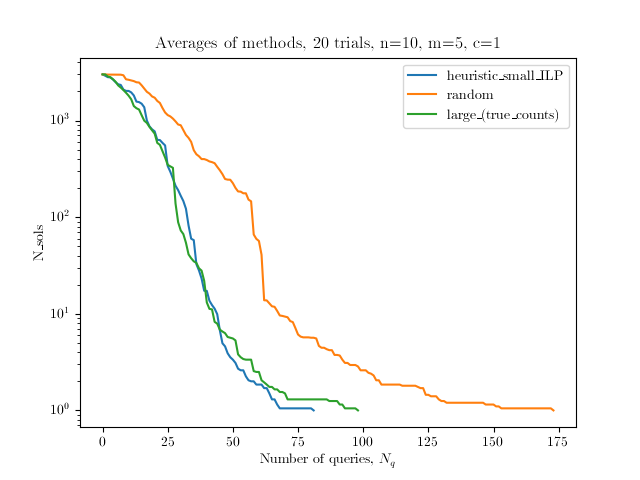

In [24]:
data = defaultdict()
# data['heuristic_small'] = [avg_the_list(heuristic_small_res['n_sols'])]
data['heuristic_small_ILP'] = [avg_the_list(heuristic_small_ILP_res['n_sols'])]
# data['heuristic'] = [avg_the_list(heuristic_res['n_sols'])]
data['random'] = [avg_the_list(random_res['n_sols'])]
data['large_(true_counts)'] = [avg_the_list(large_counts_res['n_sols'])]

plt.figure()
for method in data.keys():
    for trial in data[method]:
        x = [i for i in range(len(trial))]
        y = list(trial)
        plt.plot(x, y, label = f'{method}')

    
plt.xlabel('Number of queries, $N_q$')
plt.ylabel('N_sols')
# plt.xscale('log')
plt.yscale('log')
plt.title("Averages of methods, 20 trials, n=10, m=5, c=1")
# plt.title(f'{heading_dict[feature]} for varying $c, m=5, n=30, N_{{trials}} =30$')
# plt.title(f"$c$")
# plt.ylim([0,105])
plt.legend()
# plt.savefig(f'querying_algorithm_plots/random_heur_large_comparison_m_5.pdf') 
plt.show()

    

In [985]:
def update_atmosts(new_quers_dict,c,atmosts = defaultdict(lambda:0)):
    for quer in new_quers_dict.keys():
        for choice in powerset(range(len(quer[0]))):
            quer_update = (tuple([quer[0][i] for i in choice]),tuple([quer[1][i] for i in choice]))
            atmosts[quer_update] = max(atmosts[quer_update], new_quers_dict[quer] - c)
    return atmosts

def update_atleasts(new_quers_dict,c,atleasts = defaultdict(lambda:n)):
    """ need to define what n is first before calling this """
    for quer in new_quers_dict.keys():
        for choice in powerset(range(len(quer[0]))):
            quer_update = (tuple([quer[0][i] for i in choice]),tuple([quer[1][i] for i in choice]))
            atleasts[quer_update] = min(atmosts[quer_update], new_quers_dict[quer] + c)
    return None

In [955]:
def powerset(iterable):
    "powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))


In [965]:
quer_tst = ((0, 1, 6), (0, 1, 0))
choices = [i for i in powerset(range(len(quer_tst[0])))]
for choice in choices:
    quer = (tuple([quer_tst[0][i] for i in choice]),tuple([quer_tst[1][i] for i in choice]))
    print(quer)

((0,), (0,))
((1,), (1,))
((6,), (0,))
((0, 1), (0, 1))
((0, 6), (0, 0))
((1, 6), (1, 0))
((0, 1, 6), (0, 1, 0))


In [967]:
xxx = {'a': 2}
xxx['a'] = max(xxx['a'],4)
print(xxx)

{'a': 4}


In [975]:
nnn = 3
update_atleasts([],1,10)

defaultdict(<function <lambda> at 0x2d555d280>, {'x': 4})


In [991]:
print(current_quers_dict)
print(update_atmosts(current_quers_dict,1))

{((0, 1, 3), (1, 0, 1)): 0, ((0, 2, 3), (0, 0, 1)): 3, ((0, 2, 3), (1, 0, 1)): 0, ((3,), (1,)): 6, ((1, 2, 3), (0, 0, 0)): 2, ((0,), (1,)): 5, ((0, 2), (1, 1)): 2, ((0, 1, 2, 3), (0, 1, 0, 1)): 0, ((1, 2, 3), (1, 0, 1)): 1, ((2, 3), (1, 1)): 2}
defaultdict(<function <lambda> at 0x2d56395e0>, {((0,), (1,)): 4, ((1,), (0,)): 1, ((3,), (1,)): 5, ((0, 1), (1, 0)): 0, ((0, 3), (1, 1)): 0, ((1, 3), (0, 1)): 0, ((0, 1, 3), (1, 0, 1)): 0, ((0,), (0,)): 2, ((2,), (0,)): 2, ((0, 2), (0, 0)): 2, ((0, 3), (0, 1)): 2, ((2, 3), (0, 1)): 2, ((0, 2, 3), (0, 0, 1)): 2, ((0, 2), (1, 0)): 0, ((0, 2, 3), (1, 0, 1)): 0, ((3,), (0,)): 1, ((1, 2), (0, 0)): 1, ((1, 3), (0, 0)): 1, ((2, 3), (0, 0)): 1, ((1, 2, 3), (0, 0, 0)): 1, ((2,), (1,)): 1, ((0, 2), (1, 1)): 1, ((1,), (1,)): 0, ((0, 1), (0, 1)): 0, ((1, 2), (1, 0)): 0, ((1, 3), (1, 1)): 0, ((0, 1, 2), (0, 1, 0)): 0, ((0, 1, 3), (0, 1, 1)): 0, ((1, 2, 3), (1, 0, 1)): 0, ((0, 1, 2, 3), (0, 1, 0, 1)): 0, ((2, 3), (1, 1)): 1, ((1, 2), (1, 1)): 0})


In [24]:
n = 10
m = 3
c = 1
dist = 'uniform'
db = gen_bin_data_set(n,m)
display(db)
quersgg = gen_queries_all(m)
quer_seed_dictgg = query_seed_dict(m)
all_quer_countsgg = get_quer_counts(db,m,c,quer_seed_dictgg,dist)
true_countsgg = get_quer_counts(db,m,0,quer_seed_dictgg,dist)
display(all_quer_countsgg)
display(true_countsgg)

,att_0,att_1,att_2
0,1,0,1
1,1,0,0
2,1,0,1
3,0,1,0
4,1,0,0
5,0,0,1
6,1,1,1
7,0,0,0
8,1,0,0
9,1,0,0


defaultdict(int,
            {((0,), (1,)): 6,
             ((0, 1, 2), (0, 1, 1)): 0,
             ((0, 1, 2), (1, 0, 1)): 2,
             ((0,), (0,)): 4,
             ((0, 1), (1, 0)): 5,
             ((0, 1), (1, 1)): 0,
             ((1,), (0,)): 9,
             ((0, 1), (0, 1)): 0,
             ((0, 1, 2), (1, 1, 1)): 2,
             ((1, 2), (1, 1)): 2,
             ((0, 1, 2), (0, 1, 0)): 0,
             ((0, 2), (1, 0)): 5,
             ((0, 1, 2), (1, 1, 0)): 1,
             ((0, 1), (0, 0)): 3,
             ((0, 1, 2), (0, 0, 1)): 0,
             ((2,), (1,)): 5,
             ((1, 2), (0, 1)): 2,
             ((1, 2), (0, 0)): 4,
             ((0, 2), (0, 0)): 1,
             ((0, 2), (1, 1)): 4,
             ((2,), (0,)): 6,
             ((0, 1, 2), (0, 0, 0)): 0,
             ((0, 2), (0, 1)): 2,
             ((1,), (1,)): 1,
             ((0, 1, 2), (1, 0, 0)): 4,
             ((1, 2), (1, 0)): 2})

defaultdict(int,
            {((0,), (1,)): 7,
             ((0, 1, 2), (0, 1, 1)): 0,
             ((0, 1, 2), (1, 0, 1)): 2,
             ((0,), (0,)): 3,
             ((0, 1), (1, 0)): 6,
             ((0, 1), (1, 1)): 1,
             ((1,), (0,)): 8,
             ((0, 1), (0, 1)): 1,
             ((0, 1, 2), (1, 1, 1)): 1,
             ((1, 2), (1, 1)): 1,
             ((0, 1, 2), (0, 1, 0)): 1,
             ((0, 2), (1, 0)): 4,
             ((0, 1, 2), (1, 1, 0)): 0,
             ((0, 1), (0, 0)): 2,
             ((0, 1, 2), (0, 0, 1)): 1,
             ((2,), (1,)): 4,
             ((1, 2), (0, 1)): 3,
             ((1, 2), (0, 0)): 5,
             ((0, 2), (0, 0)): 2,
             ((0, 2), (1, 1)): 3,
             ((2,), (0,)): 6,
             ((0, 1, 2), (0, 0, 0)): 1,
             ((0, 2), (0, 1)): 1,
             ((1,), (1,)): 2,
             ((0, 1, 2), (1, 0, 0)): 4,
             ((1, 2), (1, 0)): 1})

In [23]:
count = 0
for quer in true_countsgg.keys():
    if len(quer[0]) == 3:
        count+= true_countsgg[quer]
print(count)

40
